# Project - Sales Forecasting Accuracy Increasing 

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from scipy.optimize import minimize
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('For USML.csv', sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 13 columns):
Period        81 non-null int64
Forecast 1    81 non-null int64
Actual 1      81 non-null int64
Forecast 2    81 non-null int64
Actual 2      81 non-null int64
Forecast 3    81 non-null int64
Actual 3      81 non-null int64
Forecast 4    81 non-null int64
Actual 4      81 non-null int64
Forecast 5    81 non-null int64
Actual 5      81 non-null int64
Forecast 6    81 non-null int64
Actual 6      81 non-null int64
dtypes: int64(13)
memory usage: 8.3 KB


In [3]:
data.describe()

,Period,Forecast 1,Actual 1,Forecast 2,Actual 2,Forecast 3,Actual 3,Forecast 4,Actual 4,Forecast 5,Actual 5,Forecast 6,Actual 6
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,41.000000,9056.345679,8701.000000,878.074074,992.444444,3416.753086,3237.037037,891.358025,881.888889,48.876543,165.148148,57.925926,105.925926
std,23.526581,2793.121874,2573.329633,463.331193,705.503774,1032.982424,1084.246391,380.930220,645.320754,70.220792,360.988300,80.966162,160.372830
min,1.000000,2940.000000,3885.000000,269.000000,72.000000,1500.000000,858.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,6830.000000,6867.000000,525.000000,537.000000,2640.000000,2382.000000,600.000000,408.000000,0.000000,42.000000,0.000000,12.000000
50%,41.000000,9150.000000,8109.000000,840.000000,834.000000,3300.000000,3345.000000,870.000000,738.000000,0.000000,90.000000,0.000000,51.000000
75%,61.000000,10620.000000,10611.000000,1050.000000,1311.000000,4050.000000,3762.000000,1095.000000,1182.000000,90.000000,156.000000,120.000000,120.000000
max,81.000000,15150.000000,15396.000000,3099.000000,3966.000000,5850.000000,7365.000000,1827.000000,3270.000000,426.000000,3180.000000,291.000000,879.000000


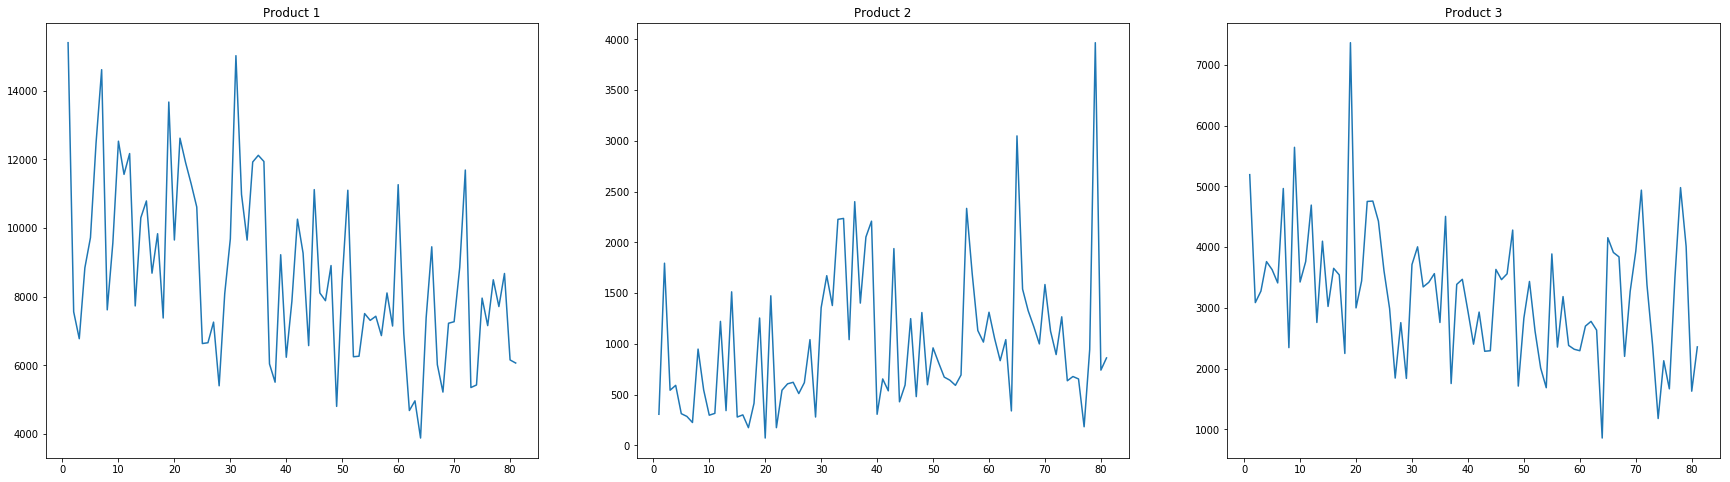

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8));
axes[0].plot(data["Period"],data["Actual 1"]);
axes[0].set_title("Product 1");
axes[1].plot(data["Period"],data["Actual 2"]);
axes[1].set_title("Product 2");
axes[2].plot(data["Period"],data["Actual 3"]);
axes[2].set_title("Product 3");

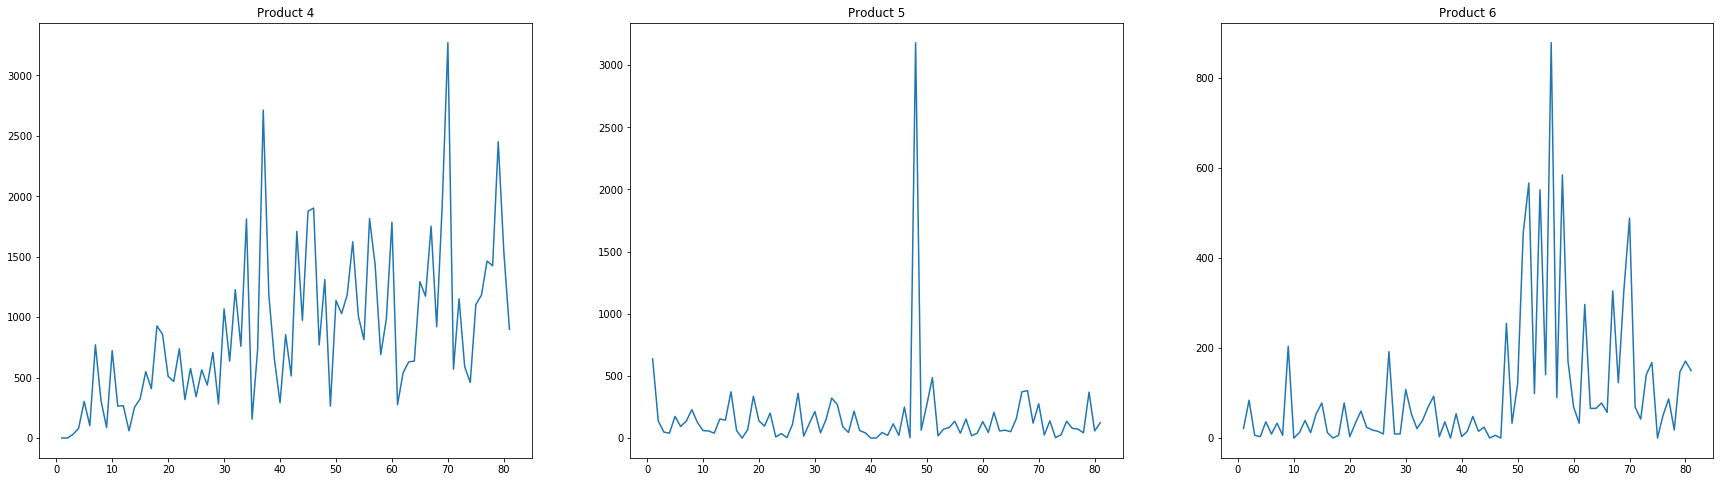

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8));
axes[0].plot(data["Period"],data["Actual 4"]);
axes[0].set_title("Product 4");
axes[1].plot(data["Period"],data["Actual 5"]);
axes[1].set_title("Product 5");
axes[2].plot(data["Period"],data["Actual 6"]);
axes[2].set_title("Product 6");

# ARIMA Product #2

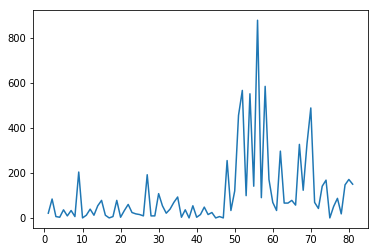

In [6]:
#We can see that Sales dataset has a clear trend. This suggests that the time series is not stationary and 
#will require differencing to make it stationary, at least a difference order of 1.
plt.plot(data["Period"],data["Actual 6"]);

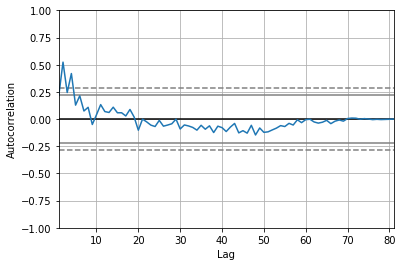

In [7]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Let’s also take a quick look at an autocorrelation plot of the time series. 
#We can see that there is no significant correlation with the lags 
#A good starting point for the AR parameter of the model may be 0.
autocorrelation_plot(data["Actual 6"]);

count     81.000000
mean     105.925926
std      160.372830
min        0.000000
25%       12.000000
50%       51.000000
75%      120.000000
max      879.000000
Name: Actual 6, dtype: float64

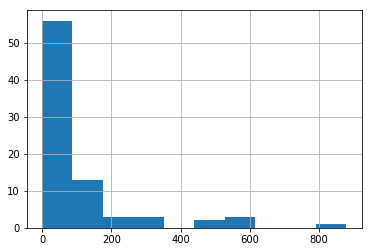

In [8]:
itog1 = data["Actual 6"].describe()
data["Actual 6"].hist()
itog1

Как можно заметить из характеристик и гистограммы, ряд у нас не однородный и имеет относительно 
большой разброс о чем свидетельствует коэффициент вариации: LaTeX:V = \frac {\sigma}{\bar{x}}, где 
        LaTeX:\sigma — cреднеквадратическое отклонение, LaTeX:\bar{x} — среднее арифметическое выборки. В нашем случае он равен:

In [9]:
print("V = %f" % (itog1['std']/itog1['mean']))

V = 1.514009


In [10]:
elements = np.array(data["Actual 6"])

mean = np.mean(elements, axis=0)
sd = np.std(elements, axis=0)

final_list5 = [x for x in data["Actual 6"] if (x > mean - 2 * sd)]
final_list5 = [x for x in final_list5 if (x < mean + 2 * sd)]
df5=pd.DataFrame(final_list5)

In [11]:
df5.tail()

,0
70,87
71,18
72,147
73,171
74,150


Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности. Для этого в существует функция jarque_bera(), которая возвращает значения данной статистики:

In [12]:
from statsmodels.iolib.table import SimpleTable
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(data["Actual 6"])
a = np.vstack([jb_test])
itog1 = SimpleTable(a, row)
print (itog1)

       JB               p-value               skew             kurtosis    
---------------------------------------------------------------------------
275.520263172584 1.484345587563859e-60 2.6250145904699185 10.35342281742983
---------------------------------------------------------------------------


#https://habr.com/post/207160/
#Значение данной статистика свидетельствует о том, нулевая гипотеза о нормальности распределения
#отвергается с большой вероятностью (probably > 0.05), и, следовательно, наш ряд НЕ имеет нормального распределения.

Многие методы и модели основаны на предположениях о стационарности ряда, но как было замечено ранее наш ряд таковым скорее всего не является. Поэтому для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле statsmodels есть функция adfuller():

In [13]:
test = sm.tsa.adfuller(data["Actual 6"])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.1360471130494783
p-value:  0.02399802139269324
Critical values:  {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}
единичных корней нет, ряд стационарен


Проведенный тест подтвердил предположения о не стационарности ряда. Во многих случаях взятие разности рядов позволяет это сделать.Если, например, первые разности ряда стационарны, то он называется интегрированным рядом первого порядка.
Итак, давайте определим порядок интегрированного ряда для нашего ряда:

In [14]:
ts1 = data["Actual 6"].diff(periods=1).dropna()

В коде выше функция diff() вычисляет разность исходного ряда с рядом с заданным смещением периода. Период смещения передается как параметр period. Т.к. в разности первое значение получиться неопределенным, то нам надо избавиться от него для этого и используется метод dropna().
Проверим получившийся ряд на стационарность:


In [15]:
test = sm.tsa.adfuller(ts1)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -8.306185904845474
p-value:  3.8980656987485014e-13
Critical values:  {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}
единичных корней нет, ряд стационарен


Как видно из кода выше получившийся ряд первых разностей приблизился к стационарному. Для полной уверенности разобъем его на несколько промежутков и убедимся мат. ожидания на разных интервалах:

In [16]:
m = ts1.index[int(len(ts1.index)/2+1)]
r1 = sm.stats.DescrStatsW(ts1[m:])
r2 = sm.stats.DescrStatsW(ts1[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.9352742332092969


Высокое p-value дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда. Осталось убедиться в отсутствии тренда для этого построим график нашего нового ряда:

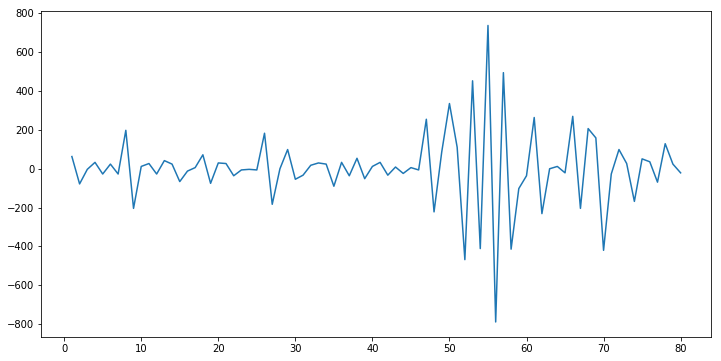

In [17]:
ts1.plot(figsize=(12,6));

Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.
Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

Параметр d есть и он равет 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.
Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов. Итак, наши функции выглядят так:

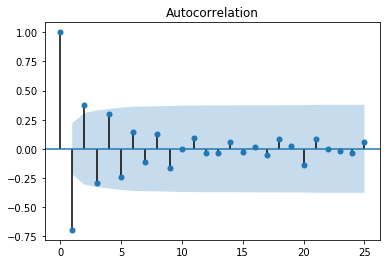

In [18]:
#ig = plt.figure(figsize=(12,8))
#ax1 = fig.add_subplot(211)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts1,lags=25);

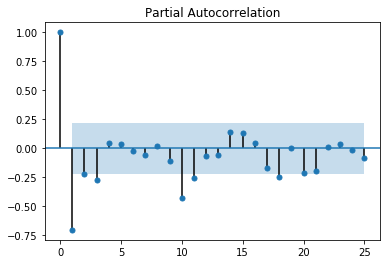

In [19]:
#ax2 = fig.add_subplot(212)
plot_pacf(ts1, lags=25);

После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля. По коррелограмме ACF можно увидеть, что q = 1, т.к. после лага 1 значении функций резко падают.
Итак, когда известны все параметры можно построить модель, но для ее построения мы возмем не все данные, а только часть. Данные из части не попавших в модель мы оставим для проверки точности прогноза нашей модели:

In [20]:
ts1_model = data["Actual 6"][:70]
model1 = sm.tsa.ARIMA(ts1_model, order=(0,1,1)).fit(disp=0)

In [21]:
print (model1.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Actual 6   No. Observations:                   69
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -444.497
Method:                       css-mle   S.D. of innovations            150.983
Date:                Tue, 19 Mar 2019   AIC                            894.994
Time:                        20:57:21   BIC                            901.696
Sample:                             1   HQIC                           897.653
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.8228      4.852      0.788      0.434      -5.687      13.333
ma.L1.D.Actual 6    -0.7455      0.101     -7.401      0.000      -0.943      -0.548
                            

Как видно из данной информации в нашей модели все коэффициенты значимые и можно перейти к оценке модели.

Проверим остатки данной модели на соответствие «белому шуму», а также проанализируем коррелограму остатков, так как это может нам помочь в определении важных для включения и прогнозирования элементов регрессии.
Итак первое, что мы сделаем это проведем Q-тест Льюнга — Бокса для проверки гипотезы о том, что остатки случайны, т. е. являются «белым шумом». Данный тест проводится на остатках модели ARIMA. Таким образом, нам надо сначала получить остатки модели и построить для них ACF, а затем к получившимся коэффициентам приметить тест. С помощью statsmadels это можно сделать так:

In [22]:
q_test = sm.tsa.stattools.acf(model1.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print (pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    3.970153  0.046314
1   14.081315  0.000876
2   14.899888  0.001904
3   20.128874  0.000471
4   21.664903  0.000606
5   21.768381  0.001334
6   24.332474  0.000996
7   24.415210  0.001952
8   31.476925  0.000245
9   33.975166  0.000186
10  34.047851  0.000355
11  35.948785  0.000330
12  36.133896  0.000566
13  36.138610  0.000995
14  36.139068  0.001688
15  36.185130  0.002727
16  36.217375  0.004290
17  36.763842  0.005624
18  37.734724  0.006413
19  37.877885  0.009165
20  38.821653  0.010308
21  38.880611  0.014563
22  38.905084  0.020322
23  38.950970  0.027634
24  39.156128  0.035534
25  39.196823  0.046684
26  39.197172  0.060790
27  39.219754  0.077453
28  39.640283  0.089992
29  40.086264  0.103204
30  40.088260  0.127062
31  40.097530  0.154010
32  40.146409  0.183013
33  40.539943  0.204115
34  40.565645  0.238326
35  40.687386  0.271606
36  40.816054  0.306369
37  41.718613  0.312297
38  41.767829  0.351448
39  41.771600  0.393744


Значение данной статистики и p-values, свидетельствуют о том, что гипотеза о случайности остатков не отвергается, и скорее всего данный процесс представляет «белый шум».
Теперь давайте расчитаем коэффициент детерминацииLaTeX:R^2, чтобы понять какой процент наблюдений описывает данная модель:

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
pred1 = model1.predict(69,80,typ="levels")
trn1 = data["Actual 6"][69:]
r2 = r2_score(trn1, pred1)
print ('R^2: %1.2f' % r2)

R^2: -2.39


In [24]:
pred1.shape

(12,)

In [25]:
trn1.shape

(12,)

In [26]:
mean_squared_error(trn1,pred1)

51289.551894983015

In [27]:
mean_absolute_error(trn1,pred1)

219.28705693205742

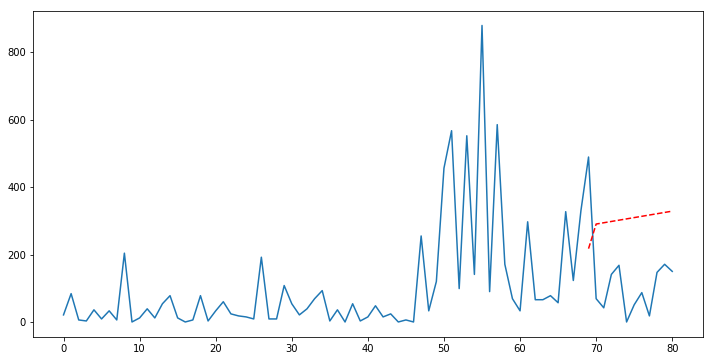

In [28]:
data["Actual 6"].plot(figsize=(12,6))
pred1.plot(style='r--');

# MAPE, GMRAE, UMBRAE

In [29]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
round(mean_absolute_percentage_error(trn1, pred1), 2)

inf

In [31]:
def gmrae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true1 = np.array(data["Actual 6"][68:80])
    return (np.prod(np.abs((y_true - y_pred)/(y_true - y_true1))))**(1/len(y_true))

In [32]:
round(gmrae(trn1, pred1), 2)

3.21

In [33]:
len(trn1)

12

In [34]:
np.array(trn1)

array([489,  69,  42, 141, 168,   0,  51,  87,  18, 147, 171, 150])

In [35]:
data["Actual 6"][68:80]

68    330
69    489
70     69
71     42
72    141
73    168
74      0
75     51
76     87
77     18
78    147
79    171
Name: Actual 6, dtype: int64

In [36]:
pred1

69    217.384970
70    290.325024
71    294.147831
72    297.970638
73    301.793445
74    305.616252
75    309.439059
76    313.261867
77    317.084674
78    320.907481
79    324.730288
80    328.553095
dtype: float64

In [85]:
def umbrae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true1 = np.array(data["Actual 6"][68:80])
    mbrae=(np.sum(np.abs(y_true - y_pred)/(np.abs(y_true - y_pred)+np.abs(y_true - y_true1))))/len(y_true)
    return mbrae/(1-mbrae)

In [86]:
round(umbrae(trn1, pred1), 2)

2.77

### DOUBLE Exponentional smoothing Product #1

In [39]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

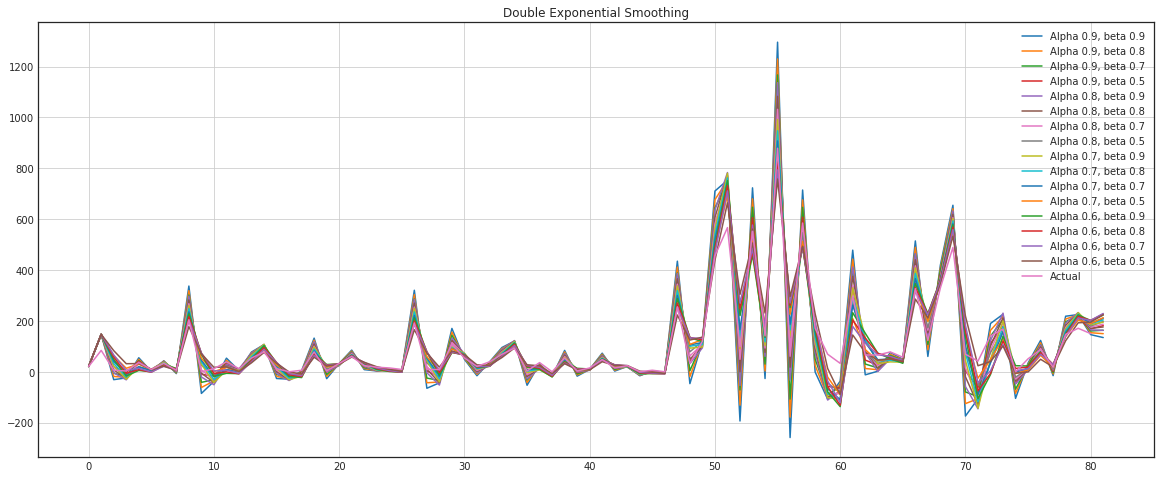

In [40]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.8,0.7,0.6]:
        for beta in [0.9, 0.8,0.7,0.5]:
            plt.plot(double_exponential_smoothing(data["Actual 6"], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(data["Actual 6"].values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Now we have to tune two parameters — α and β. The former is responsible for the series smoothing around trend, and the latter for the smoothing of the trend itself. The bigger the values, the more weight the latest observations will have and the less smoothed the model series will be. Combinations of the parameters may produce really weird results, especially if set manually. We’ll look into choosing parameters automatically in a bit, immediately after triple exponential smoothing.

In [41]:
double_exponential_smoothing(data["Actual 6"],0.9,0.1)[69:81]

[500.43897964817216,
 101.26800487959412,
 31.71678696357285,
 123.69715434524916,
 161.1824471923444,
 -0.7754437702571018,
 33.58855707280589,
 74.23198702055964,
 11.135451183484662,
 133.15360699326357,
 170.36159794484774,
 153.34985322496985]

In [42]:
data["Actual 6"][69:81]

69    489
70     69
71     42
72    141
73    168
74      0
75     51
76     87
77     18
78    147
79    171
80    150
Name: Actual 6, dtype: int64

In [43]:
for alpha in [0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
        for beta in [0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
            mape=mean_absolute_percentage_error(data["Actual 6"][69:81], double_exponential_smoothing(data["Actual 6"],alpha,beta)[69:81])
            print(alpha,"  ",beta,"  ", round(mape,3))

0.9    0.9    inf
0.9    0.8    inf
0.9    0.7    inf
0.9    0.6    inf
0.9    0.5    inf
0.9    0.4    inf
0.9    0.3    inf
0.9    0.2    inf
0.9    0.1    inf
0.8    0.9    inf
0.8    0.8    inf
0.8    0.7    inf
0.8    0.6    inf
0.8    0.5    inf
0.8    0.4    inf
0.8    0.3    inf
0.8    0.2    inf
0.8    0.1    inf
0.7    0.9    inf
0.7    0.8    inf
0.7    0.7    inf
0.7    0.6    inf
0.7    0.5    inf
0.7    0.4    inf
0.7    0.3    inf
0.7    0.2    inf
0.7    0.1    inf
0.6    0.9    inf
0.6    0.8    inf
0.6    0.7    inf
0.6    0.6    inf
0.6    0.5    inf
0.6    0.4    inf
0.6    0.3    inf
0.6    0.2    inf
0.6    0.1    inf
0.5    0.9    inf
0.5    0.8    inf
0.5    0.7    inf
0.5    0.6    inf
0.5    0.5    inf
0.5    0.4    inf
0.5    0.3    inf
0.5    0.2    inf
0.5    0.1    inf
0.4    0.9    inf
0.4    0.8    inf
0.4    0.7    inf
0.4    0.6    inf
0.4    0.5    inf
0.4    0.4    inf
0.4    0.3    inf
0.4    0.2    inf
0.4    0.1    inf
0.3    0.9    inf
0.3    0.8

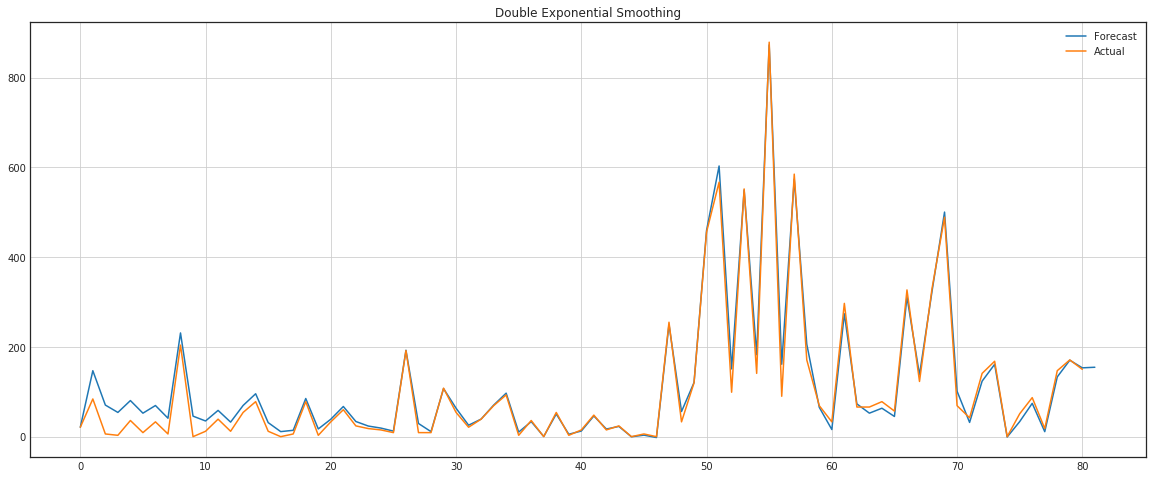

In [44]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(double_exponential_smoothing(data["Actual 6"], 0.9, 0.1), label = "Forecast");
    plt.plot(data["Actual 6"].values, label = "Actual");
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [45]:
round(mean_absolute_percentage_error(data["Actual 6"][69:81], 
                                     double_exponential_smoothing(data["Actual 6"],0.9,0.1)[69:81]),2)

inf

In [46]:
round(gmrae(data["Actual 6"][69:81], 
                                     double_exponential_smoothing(data["Actual 6"],0.9,0.1)[69:81]),2)

0.11

In [47]:
round(umbrae(data["Actual 6"][69:81], 
                                     double_exponential_smoothing(data["Actual 6"],0.9,0.1)[69:81]),2)

0.14

## LINEAR REGRESSION

In [48]:
# Creating a copy of the initial datagrame to make various transformations 
xg = pd.DataFrame(data["Actual 6"].copy())
xg.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 13):
    xg["lag_{}".format(i)] = xg.y.shift(i)

In [49]:
xg.head(13)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,84,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,84.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,6.0,84.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36,3.0,6.0,84.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,9,36.0,3.0,6.0,84.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,33,9.0,36.0,3.0,6.0,84.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
7,6,33.0,9.0,36.0,3.0,6.0,84.0,21.0,NaN,NaN,NaN,NaN,NaN
8,204,6.0,33.0,9.0,36.0,3.0,6.0,84.0,21.0,NaN,NaN,NaN,NaN
9,0,204.0,6.0,33.0,9.0,36.0,3.0,6.0,84.0,21.0,NaN,NaN,NaN


In [50]:
xg=xg.dropna()

In [51]:
y = xg["y"]
X = xg.drop(["y"], axis=1)

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [53]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    

In [54]:
# reserve 15% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.17)

In [55]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

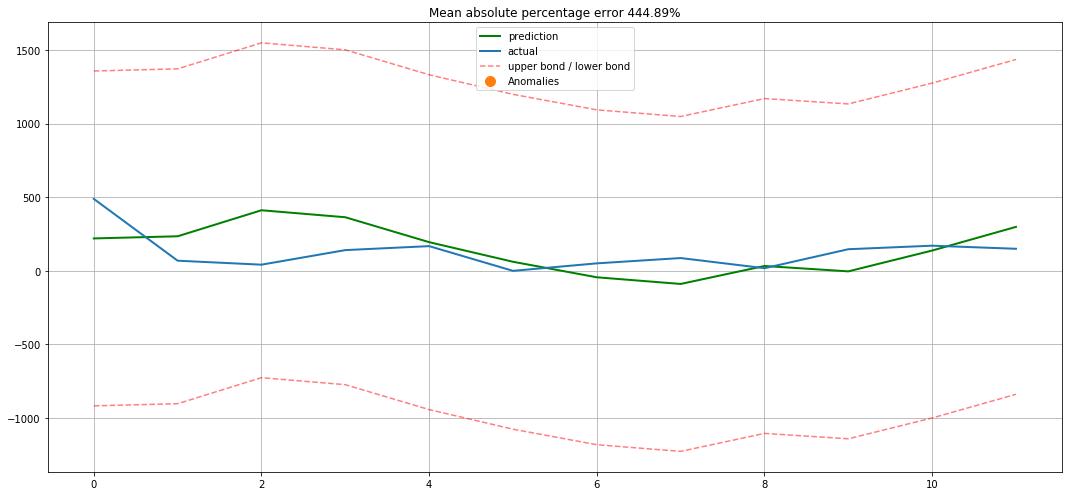

In [56]:
plotModelResults(lr, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [57]:
prediction = lr.predict(X_test)
print (prediction)

[220.33680814 234.92313996 411.79753102 364.27589932 194.94996878
  61.76705704 -43.79978288 -88.98315388  33.05239754  -3.46063734
 138.04514454 298.78761995]


In [58]:
print (y_test)

69    489
70     69
71     42
72    141
73    168
74      0
75     51
76     87
77     18
78    147
79    171
80    150
Name: y, dtype: int64


In [59]:
round(mean_absolute_percentage_error(y_test, prediction),2)

inf

In [60]:
round(gmrae(y_test, prediction), 2)

1.53

In [61]:
round(umbrae(y_test, prediction), 2)

0.58

## XGBOOST 

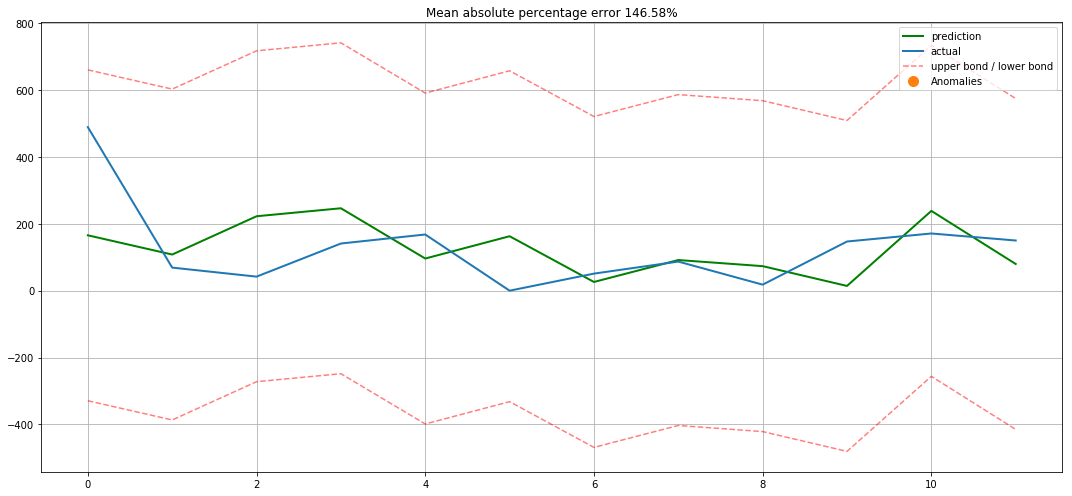

In [62]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [63]:
prediction1 = xgb.predict(X_test)
print (prediction1)

[165.56548  108.04387  222.5267   246.40195   96.11385  162.80833
  26.060173  91.61711   73.349724  14.184213 238.52893   79.83865 ]


In [64]:
round(mean_absolute_percentage_error(y_test, prediction1),2)

inf

In [65]:
round(gmrae(y_test, prediction1), 2)

1.04

In [66]:
round(umbrae(y_test, prediction1), 2)

0.52

# Facebook Prophet

In [67]:
from fbprophet import Prophet

In [68]:
ph1=pd.read_csv("For USML_date2.csv", sep=";")
ph1.tail(12)

,Date,Actual 1,Actual 2,Actual 3,Actual 4,Actual 5,Actual 6
69,31.07.2017,7272,1584,3933,3270,276,489
70,31.08.2017,8853,1125,4938,570,24,69
71,30.09.2017,11688,894,3381,1152,138,42
72,31.10.2017,5355,1266,2391,591,3,141
73,30.11.2017,5430,636,1179,459,27,168
74,31.12.2017,7959,678,2130,1104,135,0
75,31.01.2018,7158,654,1668,1182,78,51
76,28.02.2018,8493,183,3501,1464,72,87
77,31.03.2018,7713,945,4980,1425,42,18
78,30.04.2018,8676,3966,4011,2451,369,147


In [69]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [70]:
import pandas as pd
ph1 = pd.DataFrame({'ds':ph1['Date'], 'y':ph1["Actual 6"]})

In [71]:
prediction_size = 12
train_df = ph1[:-prediction_size]
train_df.tail(n=3)

,ds,y
66,30.04.2017,327
67,31.05.2017,123
68,30.06.2017,330


In [72]:
m = Prophet()
m.fit(train_df)
predictions=12
future = m.make_future_dataframe(periods=predictions, freq='M')
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [73]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
76,2018-02-28,268.645954,82.345423,372.192455,268.645952,268.645957,-45.945805,-45.945805,-45.945805,-45.945805,-45.945805,-45.945805,0.0,0.0,0.0,222.700149
77,2018-03-31,272.573026,116.718531,407.036104,272.573023,272.573029,-10.553345,-10.553345,-10.553345,-10.553345,-10.553345,-10.553345,0.0,0.0,0.0,262.019681
78,2018-04-30,276.373418,340.063033,648.761102,276.373415,276.373422,212.469819,212.469819,212.469819,212.469819,212.469819,212.469819,0.0,0.0,0.0,488.843237
79,2018-05-31,280.300490,-29.135357,278.971356,280.300487,280.300494,-152.859763,-152.859763,-152.859763,-152.859763,-152.859763,-152.859763,0.0,0.0,0.0,127.440727
80,2018-06-30,284.100882,183.216549,490.544074,284.100878,284.100887,45.564643,45.564643,45.564643,45.564643,45.564643,45.564643,0.0,0.0,0.0,329.665525


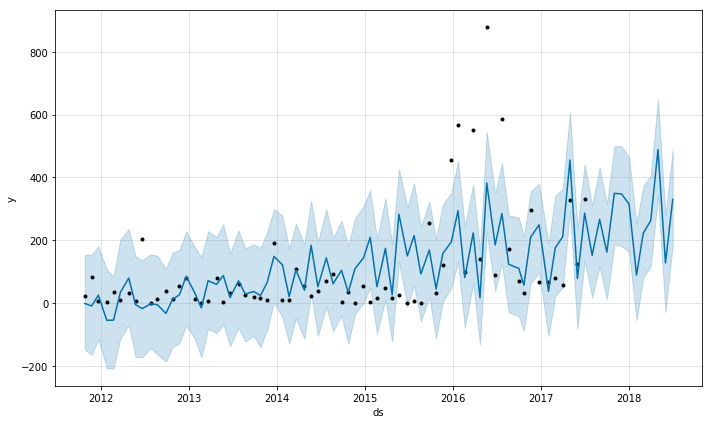

In [74]:
m.plot(forecast);

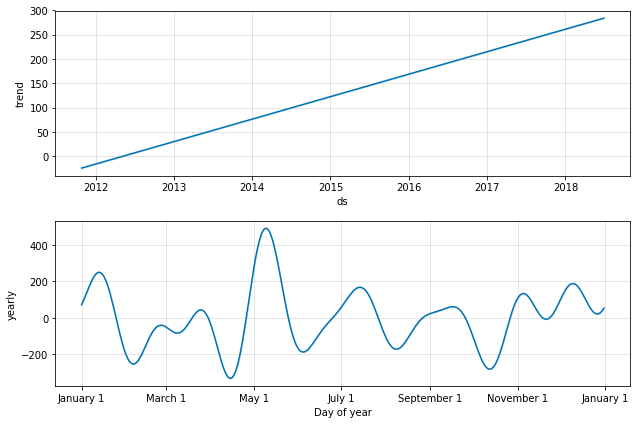

In [75]:
m.plot_components(forecast);

In [76]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index("ds"))

In [77]:
cmp_df = make_comparison_dataframe(ph1, forecast)
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-02-28,222.700149,82.345423,372.192455,87
2018-03-31,262.019681,116.718531,407.036104,18
2018-04-30,488.843237,340.063033,648.761102,147
2018-05-31,127.440727,-29.135357,278.971356,171
2018-06-30,329.665525,183.216549,490.544074,150


In [78]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [79]:
for err_name, err_value in calculate_forecast_errors(cmp_df, predictions).items():
    print(err_name, err_value)

MAPE inf
MAE 194.92773807133256


In [80]:
cmp_df['y'][-12:]

ds
2017-07-31    489
2017-08-31     69
2017-09-30     42
2017-10-31    141
2017-11-30    168
2017-12-31      0
2018-01-31     51
2018-02-28     87
2018-03-31     18
2018-04-30    147
2018-05-31    171
2018-06-30    150
Name: y, dtype: int64

In [81]:
cmp_df['yhat'][-12:]

ds
2017-07-31    151.768543
2017-08-31    266.283543
2017-09-30    161.622447
2017-10-31    349.204992
2017-11-30    347.105606
2017-12-31    314.994436
2018-01-31     88.902509
2018-02-28    222.700149
2018-03-31    262.019681
2018-04-30    488.843237
2018-05-31    127.440727
2018-06-30    329.665525
Name: yhat, dtype: float64

In [82]:
round(mean_absolute_percentage_error(cmp_df['y'][-12:], cmp_df['yhat'][-12:]),2)

inf

In [83]:
round(gmrae(cmp_df['y'][-12:], cmp_df['yhat'][-12:]), 2)

2.45

In [84]:
round(umbrae(cmp_df['y'][-12:], cmp_df['yhat'][-12:]), 2)

0.69